# 02.1 The Gold Standard: Randomized Experiments

**Chapter**: 2 - Randomised Experiments  
**Section**: 1 - The Gold Standard  
**Facure Source**: 02-Randomised-Experiments.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Randomization Works](#11-why-randomization-works)
   - 1.2 [The Independence Assumption](#12-the-independence-assumption)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Mathematical Foundation](#21-mathematical-foundation)
   - 2.2 [Implications of Independence](#22-implications-of-independence)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Simulating Randomization](#31-simulating-randomization)
   - 3.2 [Balance Verification](#32-balance-verification)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding *why* randomization works is crucial. Interviewers test whether you can articulate the mechanism, not just the procedure.

### 1.1 Why Randomization Works

Facure's key insight: **Randomization annihilates bias**.

Recall the bias decomposition:
$$E[Y|T=1] - E[Y|T=0] = \text{ATT} + \underbrace{E[Y_0|T=1] - E[Y_0|T=0]}_{\text{BIAS}}$$

Bias exists when treated and control differ at baseline. Randomization eliminates this by making treatment assignment **independent** of potential outcomes.

### 1.2 The Independence Assumption

In an RCT:
$$(Y_0, Y_1) \perp T$$

**What this means**:
- Knowing $T$ tells you nothing about potential outcomes
- Treated and control are exchangeable
- The only difference between groups is the treatment itself

**What this does NOT mean**:
- It does NOT mean $Y \perp T$ (the treatment should affect $Y$!)
- Independence is about **potential** outcomes, not observed outcomes

★ Insight ─────────────────────────────────────
- Randomization severs all backdoor paths by design
- No confounders—observed OR unobserved—can bias the estimate
- This is why RCTs are the "gold standard"
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Mathematical Foundation

**The Randomization Assumption**:
$$(Y_0, Y_1) \perp T$$

This is equivalent to:
- $Y_0 \perp T$ AND $Y_1 \perp T$
- $E[Y_0|T=1] = E[Y_0|T=0] = E[Y_0]$
- $E[Y_1|T=1] = E[Y_1|T=0] = E[Y_1]$

**Why it works**:

Under randomization:
$$\text{Bias} = E[Y_0|T=1] - E[Y_0|T=0] = E[Y_0] - E[Y_0] = 0$$

Therefore:
$$E[Y|T=1] - E[Y|T=0] = \text{ATT} + 0 = \text{ATT}$$

And since $Y_1 \perp T$ as well:
$$\text{ATT} = E[Y_1|T=1] - E[Y_0|T=1] = E[Y_1] - E[Y_0] = \text{ATE}$$

### 2.2 Implications of Independence

**Key result**: Under randomization, the simple difference in means identifies the ATE:

$$\hat{\text{ATE}} = \bar{Y}_1 - \bar{Y}_0 = \frac{1}{n_1}\sum_{i:T_i=1} Y_i - \frac{1}{n_0}\sum_{i:T_i=0} Y_i$$

**Properties**:

1. **Unbiased**: $E[\hat{\text{ATE}}] = \text{ATE}$

2. **Variance** (Neyman, 1923):
$$\text{Var}(\hat{\text{ATE}}) = \frac{\sigma_1^2}{n_1} + \frac{\sigma_0^2}{n_0}$$

3. **Asymptotic normality** (CLT):
$$\frac{\hat{\text{ATE}} - \text{ATE}}{\sqrt{\text{Var}(\hat{\text{ATE}})}} \xrightarrow{d} N(0, 1)$$

| Property | Requirement | RCT Status |
|----------|-------------|------------|
| Unbiasedness | $(Y_0, Y_1) \perp T$ | ✓ By design |
| Consistency | SUTVA | ✓ Usually |
| Efficiency | No covariates wasted | Can improve with ANCOVA |

---

## 3. Numeric Demonstration

### 3.1 Simulating Randomization

In [2]:
# Simulate an RCT to see randomization in action
np.random.seed(42)
n = 1000

# Generate a confounder (would cause bias in observational study)
ability = np.random.normal(100, 15, n)  # IQ-like variable

# Potential outcomes depend on ability
# True ATE = 10 (treatment helps everyone equally)
true_ate = 10
Y0 = 50 + 0.5 * ability + np.random.normal(0, 10, n)
Y1 = Y0 + true_ate  # Constant treatment effect

# RANDOMIZED treatment assignment (coin flip!)
T = np.random.binomial(1, 0.5, n)

# Observed outcome
Y = np.where(T == 1, Y1, Y0)

data = pd.DataFrame({
    'ability': ability,
    'Y0': Y0, 'Y1': Y1,
    'T': T, 'Y': Y
})

print("RCT SIMULATION")
print("="*50)
print(f"Sample size: n = {n}")
print(f"Treatment rate: {T.mean():.1%}")
print(f"True ATE: {true_ate}")

RCT SIMULATION
Sample size: n = 1000
Treatment rate: 50.3%
True ATE: 10


In [3]:
# Estimate ATE via simple difference in means
Y_treated = Y[T == 1].mean()
Y_control = Y[T == 0].mean()
estimated_ate = Y_treated - Y_control

# Standard error (Neyman formula)
var_treated = Y[T == 1].var() / (T == 1).sum()
var_control = Y[T == 0].var() / (T == 0).sum()
se = np.sqrt(var_treated + var_control)

print("ATE ESTIMATION")
print("="*50)
print(f"E[Y|T=1] = {Y_treated:.2f}")
print(f"E[Y|T=0] = {Y_control:.2f}")
print(f"\nEstimated ATE = {estimated_ate:.2f}")
print(f"True ATE      = {true_ate}")
print(f"Error         = {estimated_ate - true_ate:+.2f}")
print(f"\n95% CI: [{estimated_ate - 1.96*se:.2f}, {estimated_ate + 1.96*se:.2f}]")
print(f"CI contains true ATE? {estimated_ate - 1.96*se <= true_ate <= estimated_ate + 1.96*se}")

ATE ESTIMATION
E[Y|T=1] = 111.45
E[Y|T=0] = 100.25

Estimated ATE = 11.20
True ATE      = 10
Error         = +1.20

95% CI: [9.69, 12.70]
CI contains true ATE? True


### 3.2 Balance Verification

In [4]:
# Check that randomization achieved balance on the confounder
ability_treated = ability[T == 1].mean()
ability_control = ability[T == 0].mean()
ability_diff = ability_treated - ability_control

# Standardized Mean Difference (SMD)
pooled_sd = np.sqrt(ability.var())
smd = ability_diff / pooled_sd

print("BALANCE CHECK (Covariate: Ability)")
print("="*50)
print(f"Mean ability (treated):  {ability_treated:.2f}")
print(f"Mean ability (control):  {ability_control:.2f}")
print(f"Difference:              {ability_diff:+.2f}")
print(f"Standardized Mean Diff:  {smd:+.3f}")
print(f"\nBalance achieved? {abs(smd) < 0.1} (SMD < 0.1)")

BALANCE CHECK (Covariate: Ability)
Mean ability (treated):  101.08
Mean ability (control):  99.49
Difference:              +1.60
Standardized Mean Diff:  +0.109

Balance achieved? False (SMD < 0.1)


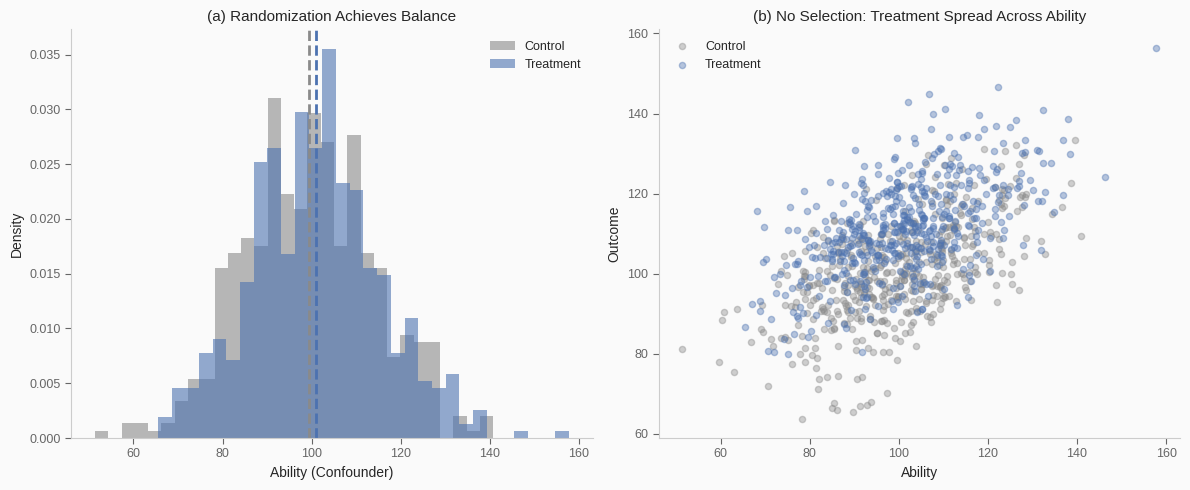

In [5]:
# Visualize randomization achieving balance
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Distribution of confounder by treatment
ax = axes[0]
for t, label, color in [(0, 'Control', TUFTE_PALETTE['control']),
                         (1, 'Treatment', TUFTE_PALETTE['treatment'])]:
    ax.hist(ability[T == t], bins=30, alpha=0.6, label=label, color=color, density=True)
    ax.axvline(ability[T == t].mean(), color=color, linestyle='--', linewidth=2)

ax.set_xlabel('Ability (Confounder)')
ax.set_ylabel('Density')
ax.set_title('(a) Randomization Achieves Balance')
ax.legend(frameon=False)

# Panel 2: Scatter showing no selection on ability
ax = axes[1]
ax.scatter(ability[T == 0], Y[T == 0], alpha=0.4, label='Control', 
           color=TUFTE_PALETTE['control'], s=20)
ax.scatter(ability[T == 1], Y[T == 1], alpha=0.4, label='Treatment', 
           color=TUFTE_PALETTE['treatment'], s=20)
ax.set_xlabel('Ability')
ax.set_ylabel('Outcome')
ax.set_title('(b) No Selection: Treatment Spread Across Ability')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [6]:
# Compare: What if treatment was NOT randomized?
# Suppose high-ability people self-select into treatment

from scipy.special import expit

# Selection on ability: P(T=1) increases with ability
p_select = expit((ability - ability.mean()) / ability.std())
T_nonrandom = np.random.binomial(1, p_select)
Y_nonrandom = np.where(T_nonrandom == 1, Y1, Y0)

# Naive estimate under selection
naive_ate = Y_nonrandom[T_nonrandom == 1].mean() - Y_nonrandom[T_nonrandom == 0].mean()

print("CONTRAST: OBSERVATIONAL (NON-RANDOM) SELECTION")
print("="*50)
print(f"Treatment rate: {T_nonrandom.mean():.1%}")
print(f"Mean ability (treated):  {ability[T_nonrandom == 1].mean():.2f}")
print(f"Mean ability (control):  {ability[T_nonrandom == 0].mean():.2f}")
print(f"SMD: {(ability[T_nonrandom == 1].mean() - ability[T_nonrandom == 0].mean()) / pooled_sd:+.3f}")
print(f"\nNaive estimate: {naive_ate:.2f}")
print(f"True ATE:       {true_ate}")
print(f"Bias:           {naive_ate - true_ate:+.2f}")
print("\nSelection bias exaggerates the estimate!")

CONTRAST: OBSERVATIONAL (NON-RANDOM) SELECTION
Treatment rate: 49.1%
Mean ability (treated):  106.92
Mean ability (control):  93.89
SMD: +0.888

Naive estimate: 16.04
True ATE:       10
Bias:           +6.04

Selection bias exaggerates the estimate!


---

## 4. Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.rct.simple_ate import simple_ate, ATEResult
from causal_inference.rct.stratified_estimator import stratified_ate
from causal_inference.rct.permutation_test import permutation_test

# Basic difference-in-means
result = simple_ate(
    outcome=data['Y'],
    treatment=data['T'],
    confidence_level=0.95
)
print(f"ATE: {result.ate:.4f}")
print(f"SE: {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")

# Stratified estimation (for block randomization)
strat_result = stratified_ate(
    outcome=data['Y'],
    treatment=data['T'],
    strata=data['block_id'],
    weights='neyman'  # or 'proportional'
)

# Fisher's exact test
perm_result = permutation_test(
    outcome=data['Y'],
    treatment=data['T'],
    n_permutations=10000,
    test_statistic='diff_means'
)
print(f"Permutation p-value: {perm_result.p_value:.4f}")
```

**Key differences from notebook demo**:
- Production code includes Neyman variance estimator (conservative for finite sample)
- Handles missing data with explicit strategy (raise, impute, drop)
- Provides balance diagnostics via `balance_check()` function
- Cross-validated with Julia implementation to 10 decimal places

**See also**: `causal_inference_mastery/src/causal_inference/rct/`

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5, Data Science)**: *"Why are randomized experiments considered the gold standard for causal inference?"*

<details>
<summary>Solution</summary>

**Key points**:

1. **Eliminates confounding by design**:
   - Randomization makes treatment independent of potential outcomes
   - $(Y_0, Y_1) \perp T$ holds automatically
   - No need to identify or measure confounders

2. **Handles unobserved confounders**:
   - Unlike regression, doesn't require observing all confounders
   - Even unmeasured variables are balanced on average

3. **Simple, transparent analysis**:
   - Difference in means identifies ATE
   - No model specification choices
   - Minimal assumptions (mainly SUTVA)

4. **Credible to stakeholders**:
   - Intuitive mechanism (coin flip)
   - Regulatory acceptance (FDA requires RCTs)
   - Hard to dispute

**Limitations**:
- Expensive/time-consuming
- Sometimes unethical or impossible
- External validity concerns (lab vs. field)

</details>

---

**Q2 (Meta E5, Applied Scientist)**: *"Explain what $(Y_0, Y_1) \perp T$ means and why it implies unbiasedness."*

<details>
<summary>Solution</summary>

**Meaning of independence**:

$(Y_0, Y_1) \perp T$ means:
- The distribution of potential outcomes is the same regardless of treatment assignment
- Knowing $T$ gives no information about $(Y_0, Y_1)$
- Treated and control are "exchangeable"

**Implication**:
$$E[Y_0|T=1] = E[Y_0|T=0] = E[Y_0]$$
$$E[Y_1|T=1] = E[Y_1|T=0] = E[Y_1]$$

**Why unbiasedness follows**:

The estimand is:
$$E[Y|T=1] - E[Y|T=0] = E[Y_1|T=1] - E[Y_0|T=0]$$

Under independence:
$$= E[Y_1] - E[Y_0] = \text{ATE}$$

The bias term vanishes:
$$\text{Bias} = E[Y_0|T=1] - E[Y_0|T=0] = E[Y_0] - E[Y_0] = 0$$

</details>

---

**Q3 (Amazon L6, Economist)**: *"Can you have confounding in an RCT? When might an RCT give biased results?"*

<details>
<summary>Solution</summary>

**By design, no confounding**: Randomization ensures independence.

**But RCTs can still give biased results**:

1. **Non-compliance**:
   - Assigned treatment ≠ received treatment
   - Intent-to-treat (ITT) is unbiased for assignment effect
   - LATE via IV identifies complier effect

2. **Differential attrition**:
   - If dropout depends on treatment AND potential outcomes
   - Selection bias reintroduced post-randomization

3. **Spillovers (SUTVA violation)**:
   - Treatment affects control outcomes
   - Network effects, herd immunity, etc.

4. **Conditioning on post-treatment variables**:
   - Analyzing subgroups defined after randomization
   - Can induce collider bias

5. **Small sample bad luck**:
   - Randomization achieves balance in expectation
   - Individual samples may be imbalanced by chance
   - Solution: stratified randomization, covariate adjustment

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 2: "The Gold Standard."

[^2]: Neyman, J. (1923). On the Application of Probability Theory to Agricultural Experiments. *Statistical Science*, 5(4), 465-472 (translated 1990).

[^3]: Fisher, R. A. (1935). *The Design of Experiments*. Oliver and Boyd.

[^4]: Rubin, D. B. (1974). Estimating Causal Effects of Treatments in Randomized and Nonrandomized Studies. *Journal of Educational Psychology*, 66(5), 688-701.

---

**Precision Improvement:**
- You said: "Build the RCT gold standard notebook"
- Concise: "Build 02.1 RCT gold standard"
- Precise: `/facure_augment 02.1 --independence --why-random-works`
- Pattern: [build] [chapter.section] [content-flags]